# 10 features(20x10x1)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = sigmoid(Z2)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A2'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 10
hidden_size = 10
output_size = 1

# Generate random input data
np.random.seed(42)
n_samples = 500

# Generate the first 33 variables using the neural network
X_first_5 = np.random.normal(loc=0, scale=1, size=(n_samples, 5))
parameters = initialize_parameters(5, hidden_size, output_size)
forward = forward_propagation(X_first_5, parameters)
y_neural_network = forward['A2']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1, size=(n_samples, input_size - 5))

# Combine the generated values
X = np.concatenate((X_first_5, X_rest), axis=1)

# Threshold for binary classification
threshold = 0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network

# Print the DataFrame
print(data.head())

       var0      var1      var2      var3      var4      var5      var6  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.479174 -0.185659   
1 -0.234137  1.579213  0.767435 -0.469474  0.542560  1.356240 -0.072010   
2 -0.463418 -0.465730  0.241962 -1.913280 -1.724918  0.361396  1.538037   
3 -0.562288 -1.012831  0.314247 -0.908024 -1.412304  0.821903  0.087047   
4  1.465649 -0.225776  0.067528 -1.424748 -0.544383 -0.219672  0.357113   

       var7      var8      var9  y  
0 -1.106335 -1.196207  0.812526  1  
1  1.003533  0.361636 -0.645120  0  
2 -0.035826  1.564644 -2.619745  1  
3 -0.299007  0.091761 -1.987569  1  
4  1.477894 -0.518270 -0.808494  1  


In [18]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [19]:
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X_knockoff = get_equi_features(X)
X_knockoff = (X_knockoff - X_knockoff.mean()) / X_knockoff.std()

In [20]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['var1_k', 'var2_k', 'var3_k', 'var4_k', 'var5_k',
                'var6_k', 'var7_k', 'var8_k', 'var9_k', 'var0_k',]
#                'var11_k', 'var12_k', 'var13_k', 'var14_k', 'var15_k',
#                 'var16_k', 'var17_k', 'var18_k', 'var19_k', 'var10_k']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
feature
feature.to_csv('smalldata_feature.csv', index=False)
Y.to_csv('smalldata_Y.csv', index=False)

## Optimizers Selection

In [28]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

LR = 0.01
BATCH_SIZE = 64
EPOCH = 50

class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [29]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

feature1 = np.array(feature)
feature1 = torch.Tensor(feature1)

y1 = torch.Tensor(Y)
y1 = y1.view(-1, 1)

torch_dataset = TensorDataset(feature1, y1)
loader = DataLoader(dataset=torch_dataset, batch_size=32, shuffle=True)

net_SGD = Net(20, 10, 1)
net_Momentum = Net(20, 10, 1)
net_RMSprop = Net(20, 10, 1)
net_Adam = Net(20, 10, 1)
net_Adagrad = Net(20, 10, 1)
net_Adadelta = Net(20, 10, 1)

In [30]:
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam, net_Adagrad, net_Adadelta]

optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
optimizer_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optimizer_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optimizer_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=LR)
optimizer_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=LR, rho=0.9, eps=1e-06)

optimzers = [optimizer_SGD, optimizer_Momentum, optimizer_RMSprop, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta]
losses_his = [[] for _ in range(len(optimzers))]

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


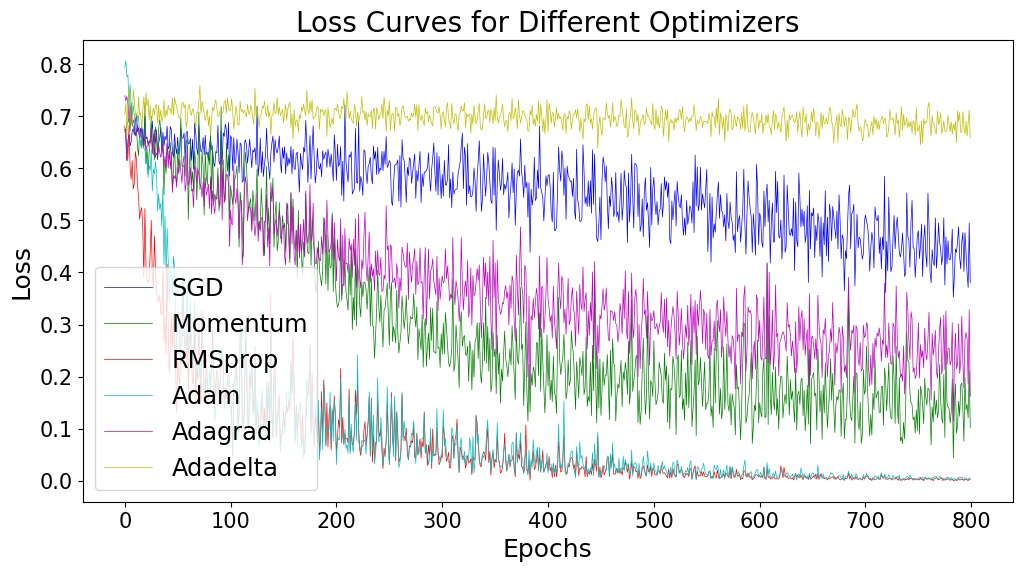

In [31]:
loss_func = nn.BCELoss()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
for epoch in range(EPOCH):
    print(f'Epoch {epoch + 1}/{EPOCH}')
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, optimizer, loss_his in zip(nets, optimzers, losses_his):
            net_output = net(batch_x)
            loss = loss_func(net_output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_his.append(loss.item())

plt.figure(figsize=(12, 6))
for i, optimizer in enumerate(optimzers):
    plt.plot(losses_his[i],label=labels[i], lw=0.5, color=colors[i])
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='xx-large')
plt.title('Loss Curves for Different Optimizers', fontsize = 20)
plt.show()

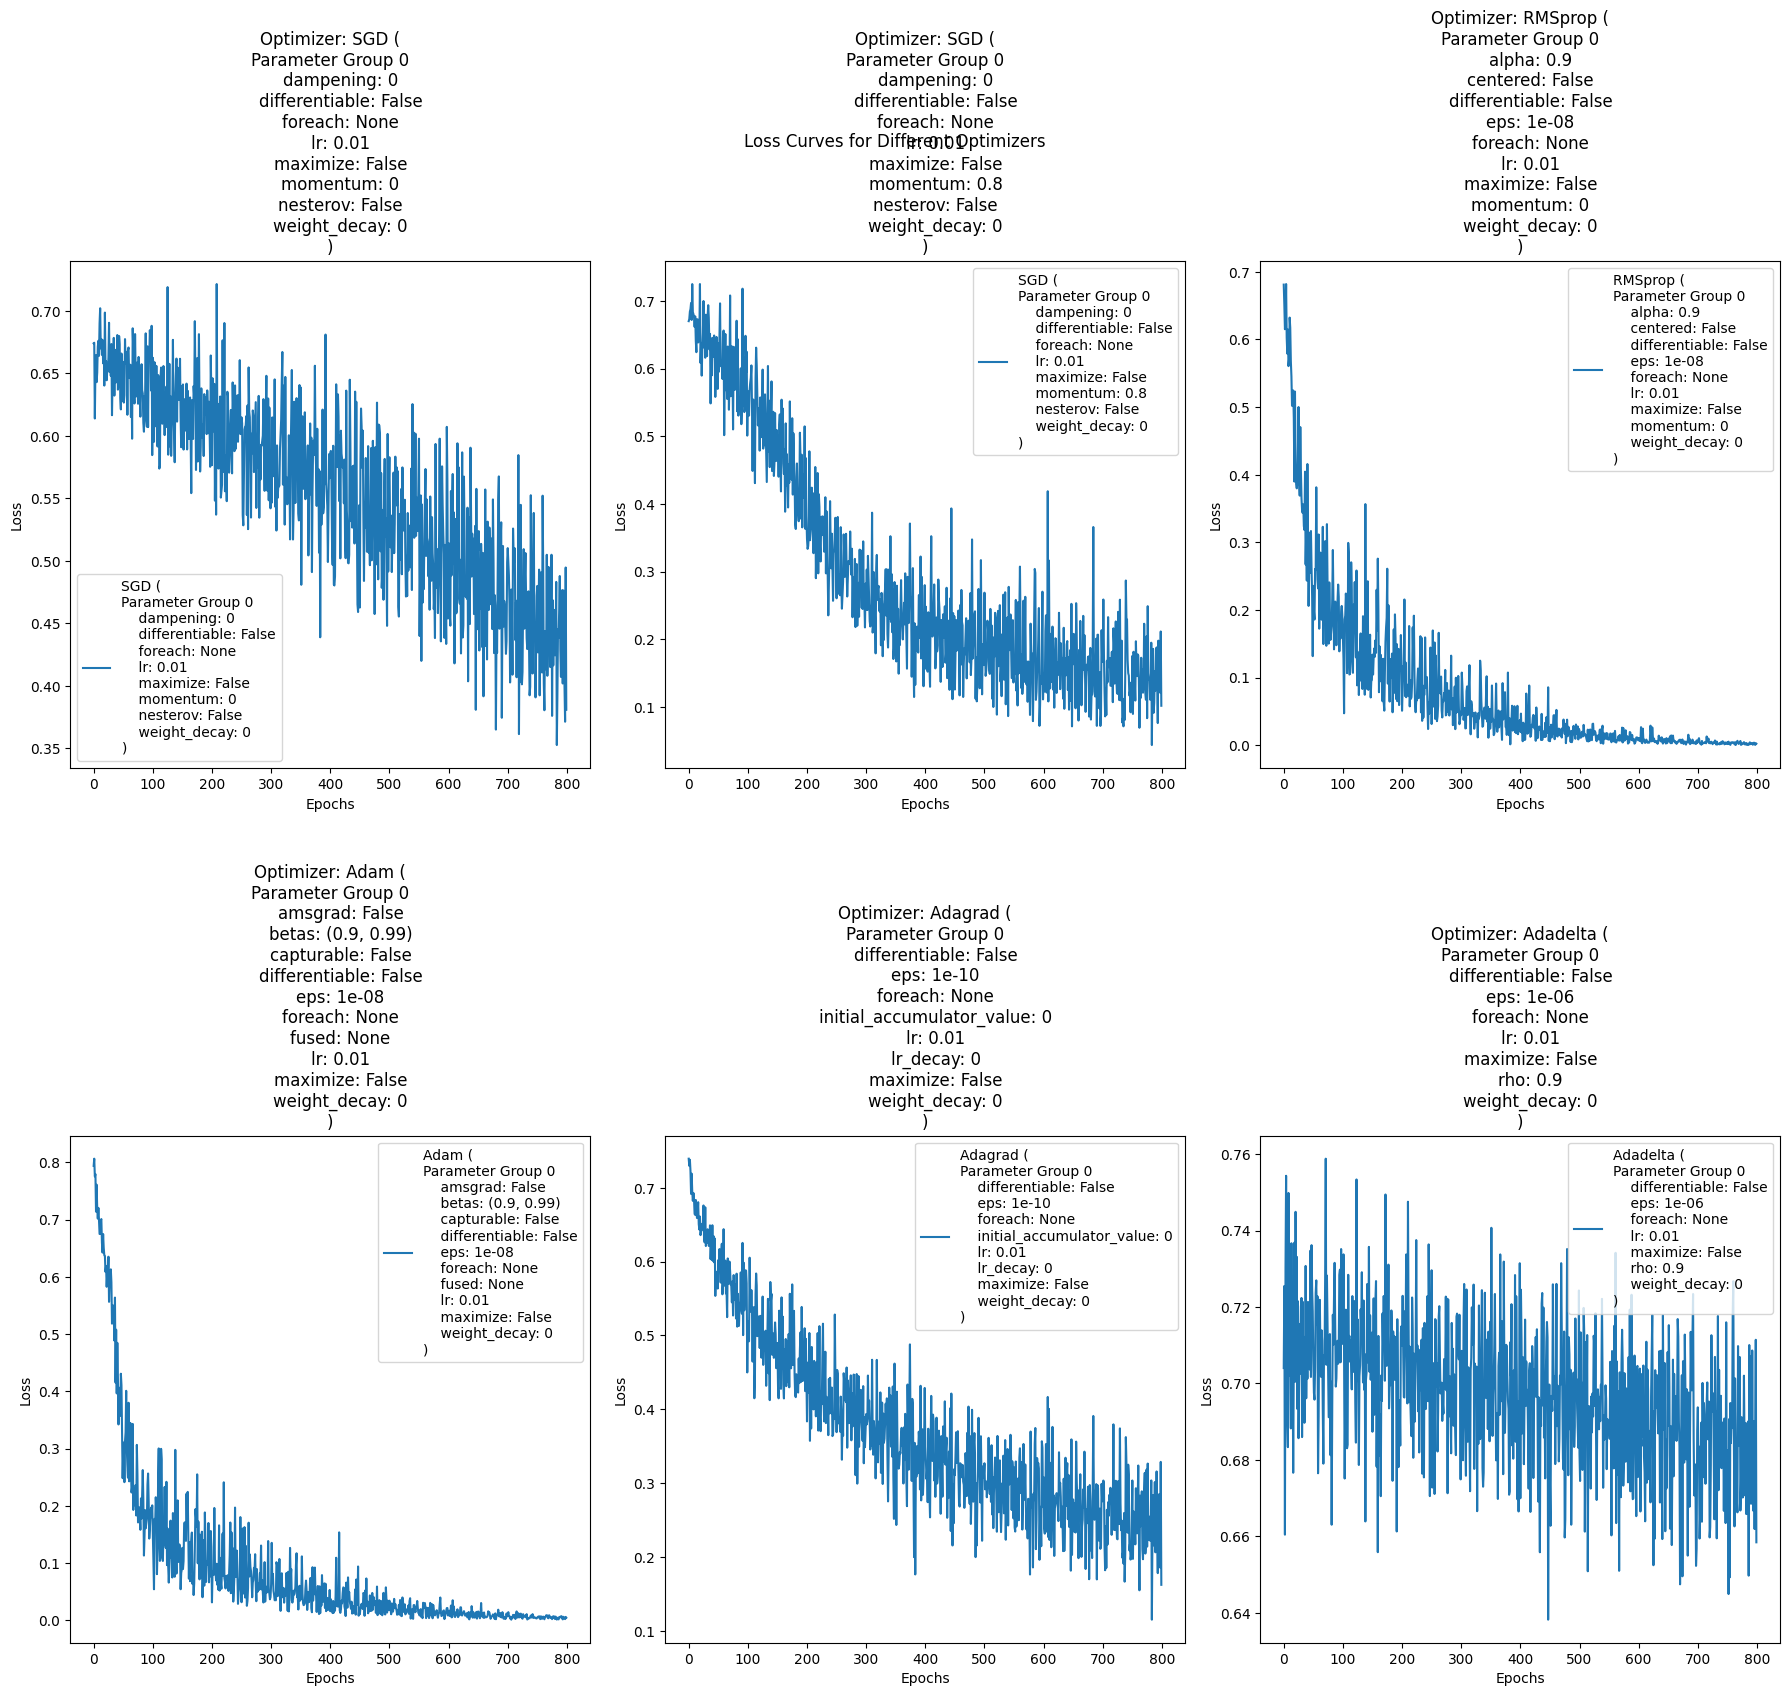

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(18, 16))
fig.suptitle('Loss Curves for Different Optimizers')

for i, (optimizer, loss_history, ax) in enumerate(zip(optimzers, losses_his, axes.flatten())):
    ax.plot(loss_history, label=f'{optimizer}')
    ax.set_title(f'Optimizer: {optimizer}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Adam

### One layer filter

In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((20,10))
input_dim = 20
for i in range(0, 5, 1):
    i = i / 20
    model_f1 = keras.Sequential()
    model_f1.add(layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model_f1.add(layers.Dense(1, activation='sigmoid'))
    model_f1 .compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_f1.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    first_layer = model_f1.layers[0]
    weights, biases = first_layer.get_weights()
    print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 0.0001 and lambda_array1[j][n]==0 :
                lambda_array1[j][n] = i

[[-1.19894505e-01  2.83821225e-01 -6.39204443e-01  2.02366766e-02
   8.96254554e-02 -2.19002903e-01  2.89946228e-01  1.37437329e-01
  -6.22240245e-01 -2.75273621e-01]
 [-7.31746018e-01  2.11086795e-01 -1.00221574e+00  9.17315066e-01
  -4.37986441e-02 -8.37606005e-03  1.15552354e+00  5.39100349e-01
  -3.25948566e-01 -2.42081895e-01]
 [ 6.07598662e-01  1.57125995e-01  3.09439987e-01 -3.54876190e-01
   8.16242769e-02 -1.86466604e-01  7.38973543e-02  1.35440558e-01
  -1.78225309e-01 -3.07390332e-01]
 [-5.66342294e-01  1.29666373e-01 -6.15711100e-02  3.19175392e-01
   2.40850568e-01  4.76388484e-01  6.70168579e-01  3.89502287e-01
   1.21568561e-01 -2.33531341e-01]
 [ 9.21138152e-02 -1.42615780e-01 -9.04178619e-01  3.47490788e-01
   3.22041273e-01  4.16001678e-01  4.27718222e-01  4.58836228e-01
  -4.63185102e-01 -2.60801792e-01]
 [-1.55039534e-01  3.64259258e-03  3.94736864e-02  4.15527642e-01
  -3.99153084e-01 -2.08031103e-01 -6.81463629e-02  2.30829760e-01
   2.72555143e-01  2.32208192e-01

In [72]:
min_lambda = np.min(abs(lambda_array1))
max_lambda = np.max(abs(lambda_array1))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.12
绝对值最大lambda值: 1.0


In [73]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 8.555490538242339e-09
绝对值最大权重值: 0.3325386345386505


In [74]:
lambda_array1 = np.where(lambda_array1 == 0, 1, lambda_array1)
row_sums = np.sum(lambda_array1 , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+10]:
        W1.append(row_sums[i])
    else:
        W1.append(-row_sums[i+10])
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 2 0.0
0 3 0.0
1 5 0.2
0 1 0.0
1 5 0.2
2 5 0.4
4 5 0.8
1 4 0.25
0 3 0.0
3 5 0.6
Variable is select:  1
Variable is select:  2
Variable is select:  4


8.04

### Multiple layers filter

In [75]:
model = model_f1
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+10]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 4, 5], array([0.5012113], dtype=float32))

## RMSprop

### one layer filter

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((20,10))
input_dim = 20
for i in range(0, 5, 1):
    i = i / 20
    model_f1 = keras.Sequential()
    model_f1.add(layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model_f1.add(layers.Dense(1, activation='sigmoid'))
    model_f1 .compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model_f1.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    first_layer = model_f1.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 0.0001 and lambda_array1[j][n]==0 :
                lambda_array1[j][n] = i

In [77]:
min_lambda = np.min(abs(lambda_array1))
max_lambda = np.max(abs(lambda_array1))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.12
绝对值最大lambda值: 1.0


In [78]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 5.7676996376100887e-39
绝对值最大权重值: 0.23101891577243805


In [79]:
lambda_array1 = np.where(lambda_array1 == 0, 1, lambda_array1)
row_sums = np.sum(lambda_array1 , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+10]:
        W1.append(row_sums[i])
    else:
        W1.append(-row_sums[i+10])
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 2 0.0
0 3 0.0
1 5 0.2
0 1 0.0
1 5 0.2
2 5 0.4
4 5 0.8
1 4 0.25
0 3 0.0
3 5 0.6
Variable is select:  1
Variable is select:  2
Variable is select:  4


8.04

### Multiple layers filter

In [80]:
model = model_f1
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+10]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 3, 4, 5, 9], array([0.81467986], dtype=float32))

## Momentum

### one layer filter

In [112]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((20,10))
input_dim = 20
for i in range(0, 5, 1):
    i = i / 20
    model_f1 = keras.Sequential()
    model_f1.add(layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model_f1.add(layers.Dense(1, activation='sigmoid'))
    
    # Create a new optimizer instance in each loop
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model_f1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    model_f1.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    first_layer = model_f1.layers[0]
    weights, biases = first_layer.get_weights()
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 0.0000001 and lambda_array1[j][n] == 0:
                lambda_array1[j][n] = i

In [113]:
min_lambda = np.min(abs(lambda_array1))
max_lambda = np.max(abs(lambda_array1))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.12
绝对值最大lambda值: 1.0


In [114]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 0.0002248813398182392
绝对值最大权重值: 0.20924672484397888


In [115]:
lambda_array1 = np.where(lambda_array1 == 0, 1, lambda_array1)
row_sums = np.sum(lambda_array1 , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+10]:
        W1.append(row_sums[i])
    else:
        W1.append(-row_sums[i+10])
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.2:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 2 0.0
0 3 0.0
1 5 0.2
0 1 0.0
1 5 0.2
2 5 0.4
4 5 0.8
1 4 0.25
0 3 0.0
3 5 0.6
Variable is select:  1
Variable is select:  2
Variable is select:  4
Variable is select:  5
Variable is select:  8


7.19

### Multiple layers filter

In [116]:
model = model_f1
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+10]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 3, 4, 5], array([7.476261], dtype=float32))

## VWA Filter

In [92]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import layers

# Assuming X is a Pandas DataFrame
X_array = X.to_numpy()

y = data['y']

num_variables = X_array.shape[1]
running_times = []
accuracies = []

for x_index in range(num_variables):
    current_x = X_array[:, x_index].reshape(-1, 1)

    input_dim = 1
    acc = []

    for i in range(25):
        model = keras.Sequential()
        model.add(layers.Dense(300, input_shape=(input_dim,)))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        model.fit(current_x, y, epochs=50, batch_size=32, verbose=0)
        predictions = model.predict(current_x)
        predicted = (predictions > 0.5)
        accuracy = accuracy_score(y, predicted)
        end_time = time.time()
        run_time = end_time - start_time

        acc.append(accuracy)

    avg_accuracy = np.mean(acc)
    accuracies.append(avg_accuracy)

print("Accuracies for each variable:", accuracies)

16/16 [==============================] - 0s 1ms/step
Accuracies for each variable: [0.6575200000000001, 0.7745599999999999, 0.6580000000000001, 0.64632, 0.68368, 0.6580000000000001, 0.6580000000000001, 0.6580000000000001, 0.6580000000000001, 0.6580000000000001]


### one-layer

In [3]:
from collections import defaultdict

accuracies = [0.6575200000000001, 0.7745599999999999, 0.6580000000000001, 0.64632, 0.68368, 0.6580000000000001, 0.6580000000000001, 0.6580000000000001, 0.6580000000000001, 0.6580000000000001]
lists = [
    [1,2,4],
    [1,2,4],
    [1,2,4,5,8],
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.1

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [1, 2, 4]
Variable weights sorted:


### multiple-layers

In [7]:
from collections import defaultdict

lists = [
    [1,2,4,5],
    [1,2,3,4,5,9],
    [1,2,3,4,5]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.1

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [1, 2, 4, 5, 3]
Variable weights sorted:


### one-layer and multiple-layers

In [6]:
from collections import defaultdict

lists = [
    [1,2,4],
    [1,2,4,5],
    [1,2,4],
    [1,2,3,4,5,9],
    [1,2,4,5,8],
    [1,2,3,4,5]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.1

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [1, 2, 4, 5, 3]
Variable weights sorted:


# 100 features(200x264x128x1)

In [119]:
import numpy as np
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size1, hidden_size2, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size1))
    b1 = np.zeros((1, hidden_size1))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size1, hidden_size2))
    b2 = np.zeros((1, hidden_size2))
    W3 = np.random.normal(loc=0, scale=1, size=(hidden_size2, output_size))
    b3 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = relu(Z2)
    Z3 = np.dot(A2, parameters['W3']) + parameters['b3']
    A3 = sigmoid(Z3)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2, 'Z3': Z3, 'A3': A3}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A3'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 100
hidden_size1 = 264
hidden_size2 = 128
output_size = 1

# Generate random input data
np.random.seed(42)
n_samples = 500

# Generate the first 33 variables using the neural network
X_first_33 = np.random.normal(loc=0, scale=1, size=(n_samples, 33))
parameters = initialize_parameters(33, hidden_size1, hidden_size2, output_size)
forward = forward_propagation(X_first_33, parameters)
y_neural_network = forward['A3']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1, size=(n_samples, input_size - 33))

# Combine the generated values
X = np.concatenate((X_first_33, X_rest), axis=1)

# Threshold for binary classification
threshold = 0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network

# Print the DataFrame
print(data.head())

       var0      var1      var2      var3      var4      var5      var6  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1 -1.057711  0.822545 -1.220844  0.208864 -1.959670 -1.328186  0.196861   
2 -0.072010  1.003533  0.361636 -0.645120  0.361396  1.538037 -0.035826   
3 -0.234587 -1.415371 -0.420645 -0.342715 -0.802277 -0.161286  0.404051   
4 -1.062304  0.473592 -0.919424  1.549934 -0.783253 -0.322062  0.813517   

       var7      var8      var9  ...     var91     var92     var93     var94  \
0  0.767435 -0.469474  0.542560  ...  0.834036 -1.000958  1.073073 -1.646456   
1  0.738467  0.171368 -0.115648  ...  0.190408 -0.262934  0.821016  1.912798   
2  1.564644 -2.619745  0.821903  ... -0.553910  0.125438 -0.580945 -0.792330   
3  1.886186  0.174578  0.257550  ... -0.961916  0.794441 -0.129540  0.648612   
4 -1.230864  0.227460  1.307143  ... -0.522786  0.553646 -0.988058  0.867964   

      var95     var96     var97     var98     var99  y  
0 -0.558788

In [120]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [121]:
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X_knockoff = get_equi_features(X)
X_knockoff = (X_knockoff - X_knockoff.mean()) / X_knockoff.std()

In [122]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['feature0_k', 'feature1_k', 'feature2_k', 'feature3_k', 'feature4_k','feature5_k', 'feature6_k', 'feature7_k', 'feature8_k', 'feature9_k',
                'feature10_k', 'feature11_k', 'feature12_k', 'feature13_k', 'feature14_k','feature15_k', 'feature16_k', 'feature17_k', 'feature18_k', 'feature19_k',
                'feature20_k', 'feature21_k', 'feature22_k', 'feature23_k', 'feature24_k','feature25_k', 'feature26_k', 'feature27_k', 'feature28_k', 'feature29_k',
                'feature30_k', 'feature31_k', 'feature32_k', 'feature33_k', 'feature34_k','feature35_k', 'feature36_k', 'feature37_k', 'feature38_k', 'feature39_k',
                'feature40_k', 'feature41_k', 'feature42_k', 'feature43_k', 'feature44_k','feature45_k', 'feature46_k', 'feature47_k', 'feature48_k', 'feature49_k',
                'feature50_k', 'feature51_k', 'feature52_k', 'feature53_k', 'feature54_k','feature55_k', 'feature56_k', 'feature57_k', 'feature58_k', 'feature59_k',
                'feature60_k', 'feature61_k', 'feature62_k', 'feature63_k', 'feature64_k','feature65_k', 'feature66_k', 'feature67_k', 'feature68_k', 'feature69_k',
                'feature70_k', 'feature71_k', 'feature72_k', 'feature73_k', 'feature74_k','feature75_k', 'feature76_k', 'feature77_k', 'feature78_k', 'feature79_k',
                'feature80_k', 'feature81_k', 'feature82_k', 'feature83_k', 'feature84_k','feature85_k', 'feature86_k', 'feature87_k', 'feature88_k', 'feature89_k',
                'feature90_k', 'feature91_k', 'feature92_k', 'feature93_k', 'feature94_k','feature95_k', 'feature96_k', 'feature97_k', 'feature98_k', 'feature99_k']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
feature.to_csv('data_feature.csv', index=False)
Y.to_csv('data_Y.csv', index=False)
feature

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,feature90_k,feature91_k,feature92_k,feature93_k,feature94_k,feature95_k,feature96_k,feature97_k,feature98_k,feature99_k
0,0.461406,-0.138062,0.678772,1.527778,-0.218823,-0.145966,1.500183,0.711481,-0.433734,0.501047,...,0.041761,-1.399550,-0.901141,-0.634283,-1.499916,-1.324173,1.808904,0.932918,-0.523871,1.564837
1,-1.059556,0.807638,-1.180781,0.244734,-2.025435,-1.232025,0.165041,0.682626,0.208686,-0.157825,...,0.728190,0.621027,-0.363863,1.604772,0.457893,-0.864506,1.364693,-0.656244,-0.178536,0.914494
2,-0.095075,0.985780,0.394094,-0.589024,0.404716,1.613266,-0.059700,1.505561,-2.589300,0.780671,...,-1.765135,-0.724497,0.596950,0.047862,0.118883,-0.863033,-0.062742,1.474685,0.325724,1.005629
3,-0.254152,-1.395087,-0.384428,-0.293781,-0.813647,-0.073646,0.365155,1.825841,0.211904,0.215750,...,-0.107524,-1.358930,0.546850,0.382886,-0.245096,0.628173,0.337488,2.455338,-1.226069,0.642411
4,-1.064050,0.464173,-0.880810,1.554045,-0.793729,-0.233248,0.760637,-1.278976,0.264916,1.266400,...,-0.556700,-0.028394,-1.273348,-0.504793,1.365226,-0.226413,-0.776064,-1.261016,0.391339,1.742916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-2.719838,0.245937,-0.380494,-0.174807,-0.923690,-0.060646,1.319356,-0.497589,1.004847,-0.849204,...,0.087845,-0.579892,0.276581,0.072000,0.953301,0.340581,-0.926859,-2.171926,-0.552606,-0.056204
496,-1.249367,0.019293,0.859484,0.192001,0.329237,1.219954,-0.738992,-0.272049,1.675527,-0.239070,...,0.601046,0.443306,0.718959,0.398436,0.656107,-0.310870,0.789619,2.249882,-0.351509,-1.360618
497,0.559587,0.877735,1.646569,1.005932,0.093156,-1.212238,0.125245,0.202628,0.747672,1.313196,...,0.790709,-0.253095,1.004977,-1.825270,0.411014,0.242115,-0.183353,-1.457800,1.605788,1.332986
498,-1.515261,0.175513,0.699545,-1.373012,-0.187130,0.797151,-2.858676,1.277270,0.391446,0.675390,...,-0.078675,0.499904,-0.422467,-0.372918,-1.554379,1.486147,-1.426416,1.246890,-0.571072,-0.228386


## Optimizers Selection

In [5]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 超参数
LR = 0.01
BATCH_SIZE = 64
EPOCH = 50

# 神经网络定义
class Net(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.output = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

feature1 = np.array(feature)
feature1 = torch.Tensor(feature1)

y1 = torch.Tensor(Y)
y1 = y1.view(-1, 1)

torch_dataset = TensorDataset(feature1, y1)
loader = DataLoader(dataset=torch_dataset, batch_size=32, shuffle=True)

net_SGD = Net(200, 264, 128, 1)
net_Momentum = Net(200, 264, 128, 1)
net_RMSprop = Net(200, 264, 128, 1)
net_Adam = Net(200, 264, 128, 1)
net_Adagrad = Net(200, 264, 128, 1)
net_Adadelta = Net(200, 264, 128, 1)

In [20]:
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam, net_Adagrad, net_Adadelta]

optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
optimizer_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optimizer_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optimizer_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=LR)
optimizer_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=LR, rho=0.9, eps=1e-06)

optimzers = [optimizer_SGD, optimizer_Momentum, optimizer_RMSprop, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta]
losses_his = [[] for _ in range(len(optimzers))]

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


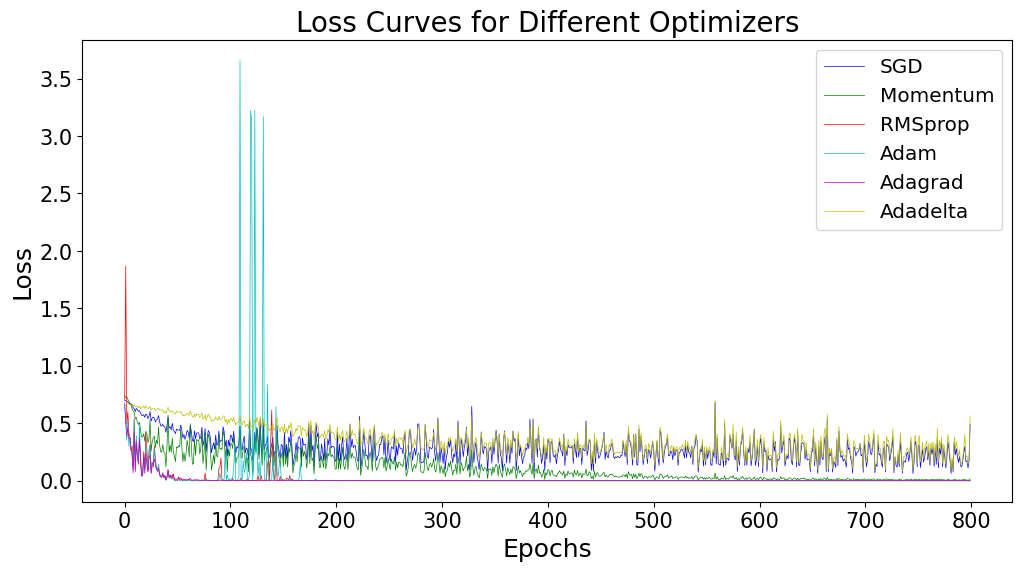

In [21]:
loss_func = nn.BCELoss()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
for epoch in range(EPOCH):
    print(f'Epoch {epoch + 1}/{EPOCH}')
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, optimizer, loss_his in zip(nets, optimzers, losses_his):
            net_output = net(batch_x)
            loss = loss_func(net_output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_his.append(loss.item())

plt.figure(figsize=(12, 6))
for i, optimizer in enumerate(optimzers):
    plt.plot(losses_his[i],label=labels[i], lw=0.5, color=colors[i])
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')
plt.title('Loss Curves for Different Optimizers', fontsize = 20)
plt.show()

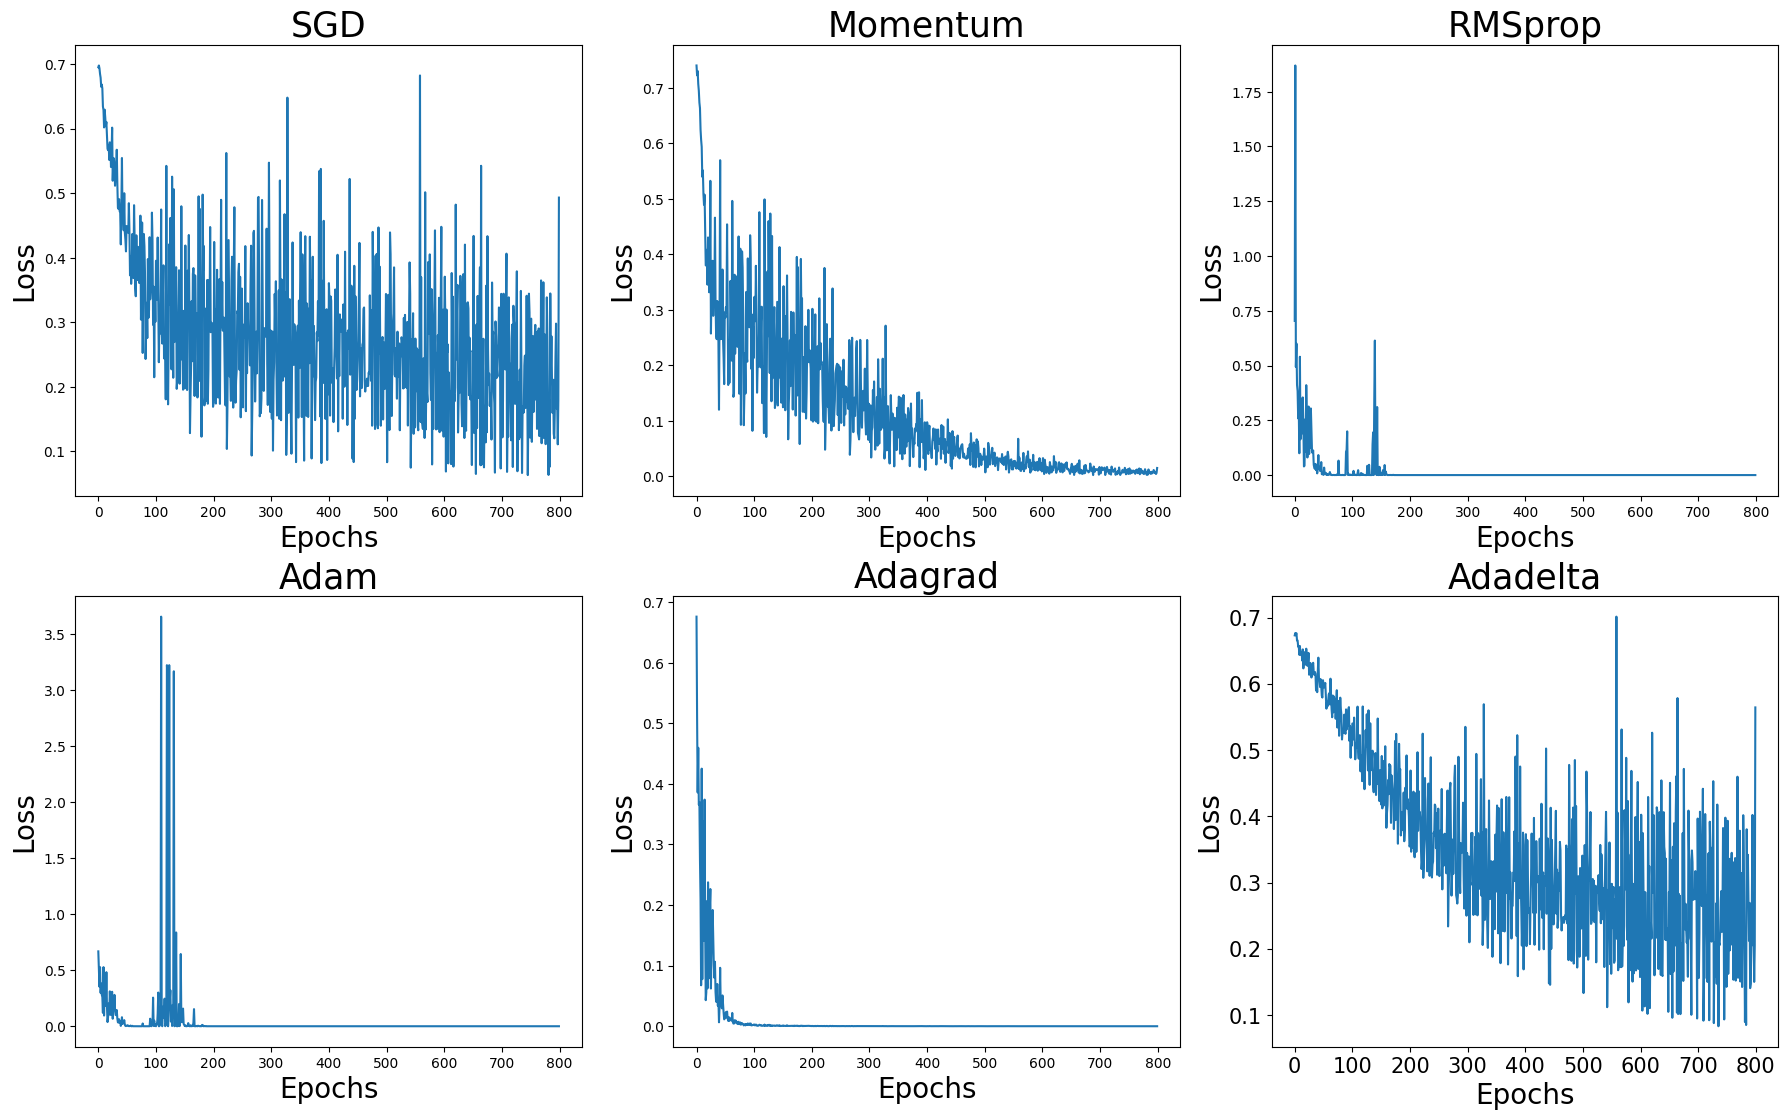

In [22]:
import matplotlib.pyplot as plt

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (optimizer, loss_history, ax) in enumerate(zip(optimzers, losses_his, axes.flatten())):
    ax.plot(loss_history)
    ax.set_title(labels[i], fontsize = 25)
    ax.set_xlabel('Epochs', fontsize = 20)
    ax.set_ylabel('Loss', fontsize = 20)
    ax.legend()

for ax in axes.flatten():
    ax.legend().set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Adam

### one layer filter

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)

    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    for j in range(min(len(weights), len(lambda_array))):
        for n in range(min(len(weights[j]), len(lambda_array[j]))):
            if abs(weights[j][n]) < 5e-4 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

In [45]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

12 24 0.5
43 48 0.8958333333333334
13 25 0.52
29 36 0.8055555555555556
19 34 0.5588235294117647
2 10 0.2
14 27 0.5185185185185185
0 2 0.0
39 45 0.8666666666666667
3 11 0.2727272727272727
35 43 0.813953488372093
14 28 0.5
1 5 0.2
1 10 0.1
21 35 0.6
9 20 0.45
7 13 0.5384615384615384
0 1 0.0
38 43 0.8837209302325582
32 40 0.8
10 23 0.43478260869565216
1 4 0.25
31 39 0.7948717948717948
10 23 0.43478260869565216
32 40 0.8
34 42 0.8095238095238095
7 17 0.4117647058823529
1 9 0.1111111111111111
19 34 0.5588235294117647
0 3 0.0
30 37 0.8108108108108109
34 42 0.8095238095238095
17 30 0.5666666666666667
1 7 0.14285714285714285
19 34 0.5588235294117647
25 35 0.7142857142857143
9 22 0.4090909090909091
1 8 0.125
7 14 0.5
9 22 0.4090909090909091
16 29 0.5517241379310345
1 6 0.16666666666666666
7 18 0.3888888888888889
41 46 0.8913043478260869
46 50 0.92
37 43 0.8604651162790697
8 19 0.42105263157894735
28 36 0.7777777777777778
36 43 0.8372093023255814
19 34 0.5588235294117647
12 24 0.5
30 37 0.810810

0.00398

### Multiple layers filter

In [46]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([8, 13, 18, 22, 30], array([9.186106e-06], dtype=float32))

## Adagrad

### one layer filter

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)

    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    for j in range(min(len(weights), len(lambda_array))):
        for n in range(min(len(weights[j]), len(lambda_array[j]))):
            if abs(weights[j][n]) < 1e-2 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.2  0.05 0.   ... 0.05 0.2  0.  ]
 [0.   0.05 0.15 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.15 0.2 ]
 ...
 [0.2  0.15 0.05 ... 0.2  0.2  0.  ]
 [0.   0.   0.05 ... 0.2  0.   0.05]
 [0.1  0.   0.   ... 0.   0.   0.  ]]


In [68]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 3.2288926377077587e-07
绝对值最大权重值: 0.07476799935102463


In [69]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.2


In [70]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

3 7 0.42857142857142855
31 49 0.6326530612244898
10 21 0.47619047619047616
5 9 0.5555555555555556
28 40 0.7
38 61 0.6229508196721312
9 18 0.5
23 36 0.6388888888888888
35 55 0.6363636363636364
29 45 0.6444444444444445
29 44 0.6590909090909091
31 51 0.6078431372549019
0 1 0.0
10 24 0.4166666666666667
25 36 0.6944444444444444
8 14 0.5714285714285714
2 6 0.3333333333333333
0 1 0.0
38 59 0.6440677966101694
9 17 0.5294117647058824
10 20 0.5
27 39 0.6923076923076923
5 9 0.5555555555555556
16 27 0.5925925925925926
37 58 0.6379310344827587
17 27 0.6296296296296297
23 36 0.6388888888888888
6 11 0.5454545454545454
10 22 0.45454545454545453
21 33 0.6363636363636364
38 61 0.6229508196721312
19 30 0.6333333333333333
36 57 0.631578947368421
29 43 0.6744186046511628
9 19 0.47368421052631576
27 39 0.6923076923076923
33 53 0.6226415094339622
31 46 0.6739130434782609
27 38 0.7105263157894737
6 10 0.6
16 26 0.6153846153846154
8 13 0.6153846153846154
23 35 0.6571428571428571
31 51 0.6078431372549019
4 7 0.

0.07749500000000001

### Multiple layers filter

In [71]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([22, 76, 85, 90, 99], array([4980.9375], dtype=float32))

## RMSprop

### one layer filter

In [101]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 2, 1):
    i = i / 50
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 5e-3 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


In [102]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

13 20 0.65
34 46 0.7391304347826086
29 29 1.0
31 38 0.8157894736842105
33 42 0.7857142857142857
12 18 0.6666666666666666
9 15 0.6
8 12 0.6666666666666666
40 47 0.851063829787234
9 13 0.6923076923076923
40 47 0.851063829787234
24 24 1.0
0 2 0.0
5 11 0.45454545454545453
20 23 0.8695652173913043
0 2 0.0
15 21 0.7142857142857143
2 4 0.5
26 26 1.0
43 48 0.8958333333333334
0 1 0.0
2 5 0.4
34 46 0.7391304347826086
8 12 0.6666666666666666
31 39 0.7948717948717948
29 29 1.0
2 9 0.2222222222222222
2 8 0.25
13 20 0.65
9 16 0.5625
26 26 1.0
30 30 1.0
23 24 0.9583333333333334
19 22 0.8636363636363636
31 36 0.8611111111111112
2 9 0.2222222222222222
15 21 0.7142857142857143
2 7 0.2857142857142857
34 46 0.7391304347826086
17 21 0.8095238095238095
1 3 0.3333333333333333
1 3 0.3333333333333333
11 18 0.6111111111111112
38 46 0.8260869565217391
45 49 0.9183673469387755
30 30 1.0
10 16 0.625
32 41 0.7804878048780488
47 52 0.9038461538461539
4 11 0.36363636363636365
20 23 0.8695652173913043
31 40 0.775
5 11

0.05182199999999999

### Multiple layers filter

In [103]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([13, 18, 21, 22, 38, 88], array([26059.453], dtype=float32))

## VWA Filter

In [124]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import layers

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

num_variables = X.shape[1]
running_times = []
accuracies = []

for x_index in range(num_variables):
    current_x = X[:, x_index].reshape(-1, 1)

    input_dim = 1
    acc = []

    for i in range(10):
        model = keras.Sequential()
        model.add(layers.Dense(264, input_shape=(input_dim,), activation='relu'))  # Additional hidden layer
        model.add(layers.Dense(128, activation='relu'))  # Second hidden layer
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        model.fit(current_x, y, epochs=50, batch_size=32, verbose=0)
        predictions = model.predict(current_x)
        predicted = (predictions > 0.5)
        accuracy = accuracy_score(y, predicted)
        end_time = time.time()
        run_time = end_time - start_time

        acc.append(accuracy)

    avg_accuracy = np.mean(acc)
    
    accuracies.append(avg_accuracy)

print("Accuracies for each variable:", accuracies)

16/16 [==============================] - 0s 1ms/step
Accuracies for each variable: [0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.91200000000000

### one layer 

In [9]:
from collections import defaultdict

lists = [
    [8,18,30],
    [13],
    [13,21]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [13]


### Multiple layers

In [10]:
from collections import defaultdict

lists = [
    [8, 13, 18, 22, 30],
    [22, 76, 85, 90, 99],
    [13, 18, 21, 22, 38, 88]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [13, 18, 22]


### one layer and multiple layers

In [8]:
from collections import defaultdict

accuracies = [0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001, 0.9120000000000001]
lists = [
    [8,18,30],
    [8, 13, 18, 22, 30],
    [13],
    [22, 76, 85, 90, 99],
    [13,21],
    [13, 18, 21, 22, 38, 88]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [8, 18, 30, 13, 22, 21]


# 100 Features(chi-square distribution)

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = sigmoid(Z2)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A2'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 100
hidden_size = 264
output_size = 1

# Generate random input data
np.random.seed(42)
n_samples = 500

# Generate the first 33 variables using the neural network
X_first_33 = np.random.chisquare(df=2, size=(n_samples, 33))
parameters = initialize_parameters(33, hidden_size, output_size)
forward = forward_propagation(X_first_33, parameters)
y_neural_network = forward['A2']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1, size=(n_samples, input_size - 33))

# Combine the generated values
X = np.concatenate((X_first_33, X_rest), axis=1)

# Threshold for binary classification
threshold = 0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network

# Print the DataFrame
print(data.head())

       var0      var1      var2      var3      var4      var5      var6  \
0  0.938536  6.020243  2.633491  1.825885  0.339250  0.339193  0.119678   
1  5.947376  6.741261  3.304663  0.726576  0.205555  2.305502  1.160182   
2  0.303796  3.240967  0.154952  8.668293  2.958968  0.443079  0.011075   
3  0.228335  0.063867  2.023459  0.754793  1.420874  4.762531  0.573478   
4  0.255361  0.823817  5.726242  0.780768  1.462906  2.428174  0.903949   

       var7      var8      var9  ...     var91     var92     var93     var94  \
0  4.022462  1.838164  2.462500  ... -0.029352  0.395307  0.033023  1.346941   
1  0.260304  1.367094  0.069987  ...  1.021963  0.733179  1.378143 -0.990623   
2  3.379794  2.454192  2.611326  ...  0.272634  0.342226 -1.098679  0.044570   
3  1.056564  2.817498  0.519610  ... -1.312467  0.536389 -1.671147 -0.838362   
4  7.135596  6.564020  0.580123  ...  0.534347 -1.768415  0.995168  0.937367   

      var95     var96     var97     var98     var99  y  
0  0.774023

In [77]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [78]:
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X_knockoff = get_equi_features(X)
X_knockoff = (X_knockoff - X_knockoff.mean()) / X_knockoff.std()

In [79]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['feature0_k', 'feature1_k', 'feature2_k', 'feature3_k', 'feature4_k','feature5_k', 'feature6_k', 'feature7_k', 'feature8_k', 'feature9_k',
                'feature10_k', 'feature11_k', 'feature12_k', 'feature13_k', 'feature14_k','feature15_k', 'feature16_k', 'feature17_k', 'feature18_k', 'feature19_k',
                'feature20_k', 'feature21_k', 'feature22_k', 'feature23_k', 'feature24_k','feature25_k', 'feature26_k', 'feature27_k', 'feature28_k', 'feature29_k',
                'feature30_k', 'feature31_k', 'feature32_k', 'feature33_k', 'feature34_k','feature35_k', 'feature36_k', 'feature37_k', 'feature38_k', 'feature39_k',
                'feature40_k', 'feature41_k', 'feature42_k', 'feature43_k', 'feature44_k','feature45_k', 'feature46_k', 'feature47_k', 'feature48_k', 'feature49_k',
                'feature50_k', 'feature51_k', 'feature52_k', 'feature53_k', 'feature54_k','feature55_k', 'feature56_k', 'feature57_k', 'feature58_k', 'feature59_k',
                'feature60_k', 'feature61_k', 'feature62_k', 'feature63_k', 'feature64_k','feature65_k', 'feature66_k', 'feature67_k', 'feature68_k', 'feature69_k',
                'feature70_k', 'feature71_k', 'feature72_k', 'feature73_k', 'feature74_k','feature75_k', 'feature76_k', 'feature77_k', 'feature78_k', 'feature79_k',
                'feature80_k', 'feature81_k', 'feature82_k', 'feature83_k', 'feature84_k','feature85_k', 'feature86_k', 'feature87_k', 'feature88_k', 'feature89_k',
                'feature90_k', 'feature91_k', 'feature92_k', 'feature93_k', 'feature94_k','feature95_k', 'feature96_k', 'feature97_k', 'feature98_k', 'feature99_k']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
feature.to_csv('data_feature.csv', index=False)
Y.to_csv('data_Y.csv', index=False)
feature

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,feature90_k,feature91_k,feature92_k,feature93_k,feature94_k,feature95_k,feature96_k,feature97_k,feature98_k,feature99_k
0,-0.594483,2.143889,0.346409,-0.108246,-0.723891,-0.787019,-0.980333,0.986850,-0.036408,0.225705,...,-0.998236,-0.961736,-0.171670,-0.211883,2.131388,1.070079,-1.146989,-1.596502,-1.126933,0.483494
1,1.983966,2.528315,0.703634,-0.669314,-0.789746,0.216274,-0.420420,-0.841952,-0.273451,-0.900236,...,0.447698,-1.254335,0.005249,-0.126564,-0.569158,1.208648,-0.701872,0.489619,0.308247,-0.691310
2,-0.921234,0.662057,-0.972771,3.383999,0.566528,-0.734012,-1.038774,0.674446,0.273577,0.295744,...,0.347962,1.220373,0.463493,-0.311649,0.922325,-0.549675,-1.732313,0.064183,0.705165,0.028319
3,-0.960080,-1.031883,0.021725,-0.654912,-0.191105,1.469954,-0.736135,-0.454887,0.456393,-0.688639,...,2.104187,-2.690759,0.850367,-0.849070,0.421005,0.921300,-0.602124,-1.901870,-0.696669,1.723531
4,-0.946168,-0.626699,1.992497,-0.641655,-0.170401,0.278867,-0.558303,2.500158,2.341645,-0.660161,...,1.580735,1.343376,-1.305376,0.953093,-0.286708,2.060419,-1.089923,0.193128,1.839179,0.823275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.542718,-0.615276,-0.596799,-0.240785,-0.414477,-0.958633,0.371503,0.385981,0.421689,-0.534894,...,2.385229,-1.558092,0.757935,0.644082,2.796889,1.544742,1.141441,-1.087615,-0.088143,1.182474
496,-0.495291,-1.003674,-0.111093,0.400967,-0.365649,-0.403794,-0.945262,-0.749184,-0.792264,-0.314624,...,-0.200707,0.878240,-2.195088,0.111452,-0.462629,-0.203993,-0.976953,0.255923,-1.481053,0.271645
497,0.557629,-0.465788,-0.411402,1.118432,1.338155,-0.681790,-0.805598,-0.301896,1.358742,-0.566914,...,0.566015,0.352672,0.283681,-0.973462,0.536691,0.656472,-0.749389,1.915450,0.159531,1.515971
498,-0.709491,0.088073,0.210813,0.202873,0.239869,-0.450960,-0.504157,-0.682535,-0.789691,0.177027,...,-1.276722,0.138870,-0.007579,0.978893,-1.306785,1.257880,-0.702822,0.521725,-2.434975,0.408509


## Optimizers Selection

In [81]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 超参数
LR = 0.01
BATCH_SIZE = 64
EPOCH = 50

# 神经网络定义
class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [83]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

feature1 = np.array(feature)
feature1 = torch.Tensor(feature1)

y1 = torch.Tensor(Y)
y1 = y1.view(-1, 1)

torch_dataset = TensorDataset(feature1, y1)
loader = DataLoader(dataset=torch_dataset, batch_size=32, shuffle=True)

net_SGD = Net(200, 264, 1)
net_Momentum = Net(200, 264, 1)
net_RMSprop = Net(200, 264, 1)
net_Adam = Net(200, 264, 1)
net_Adagrad = Net(200, 264, 1)
net_Adadelta = Net(200, 264, 1)

In [84]:
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam, net_Adagrad, net_Adadelta]

optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
optimizer_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optimizer_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optimizer_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=LR)
optimizer_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=LR, rho=0.9, eps=1e-06)

optimzers = [optimizer_SGD, optimizer_Momentum, optimizer_RMSprop, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta]
losses_his = [[] for _ in range(len(optimzers))]

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


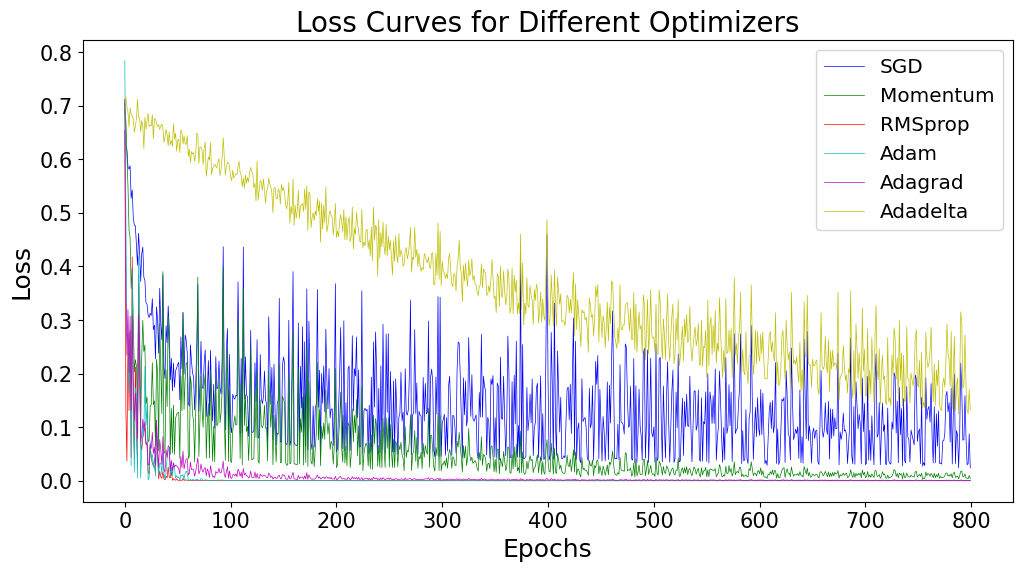

In [85]:
loss_func = nn.BCELoss()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
for epoch in range(EPOCH):
    print(f'Epoch {epoch + 1}/{EPOCH}')
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, optimizer, loss_his in zip(nets, optimzers, losses_his):
            net_output = net(batch_x)
            loss = loss_func(net_output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_his.append(loss.item())

plt.figure(figsize=(12, 6))
for i, optimizer in enumerate(optimzers):
    plt.plot(losses_his[i],label=labels[i], lw=0.5, color=colors[i])
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')
plt.title('Loss Curves for Different Optimizers', fontsize = 20)
plt.show()

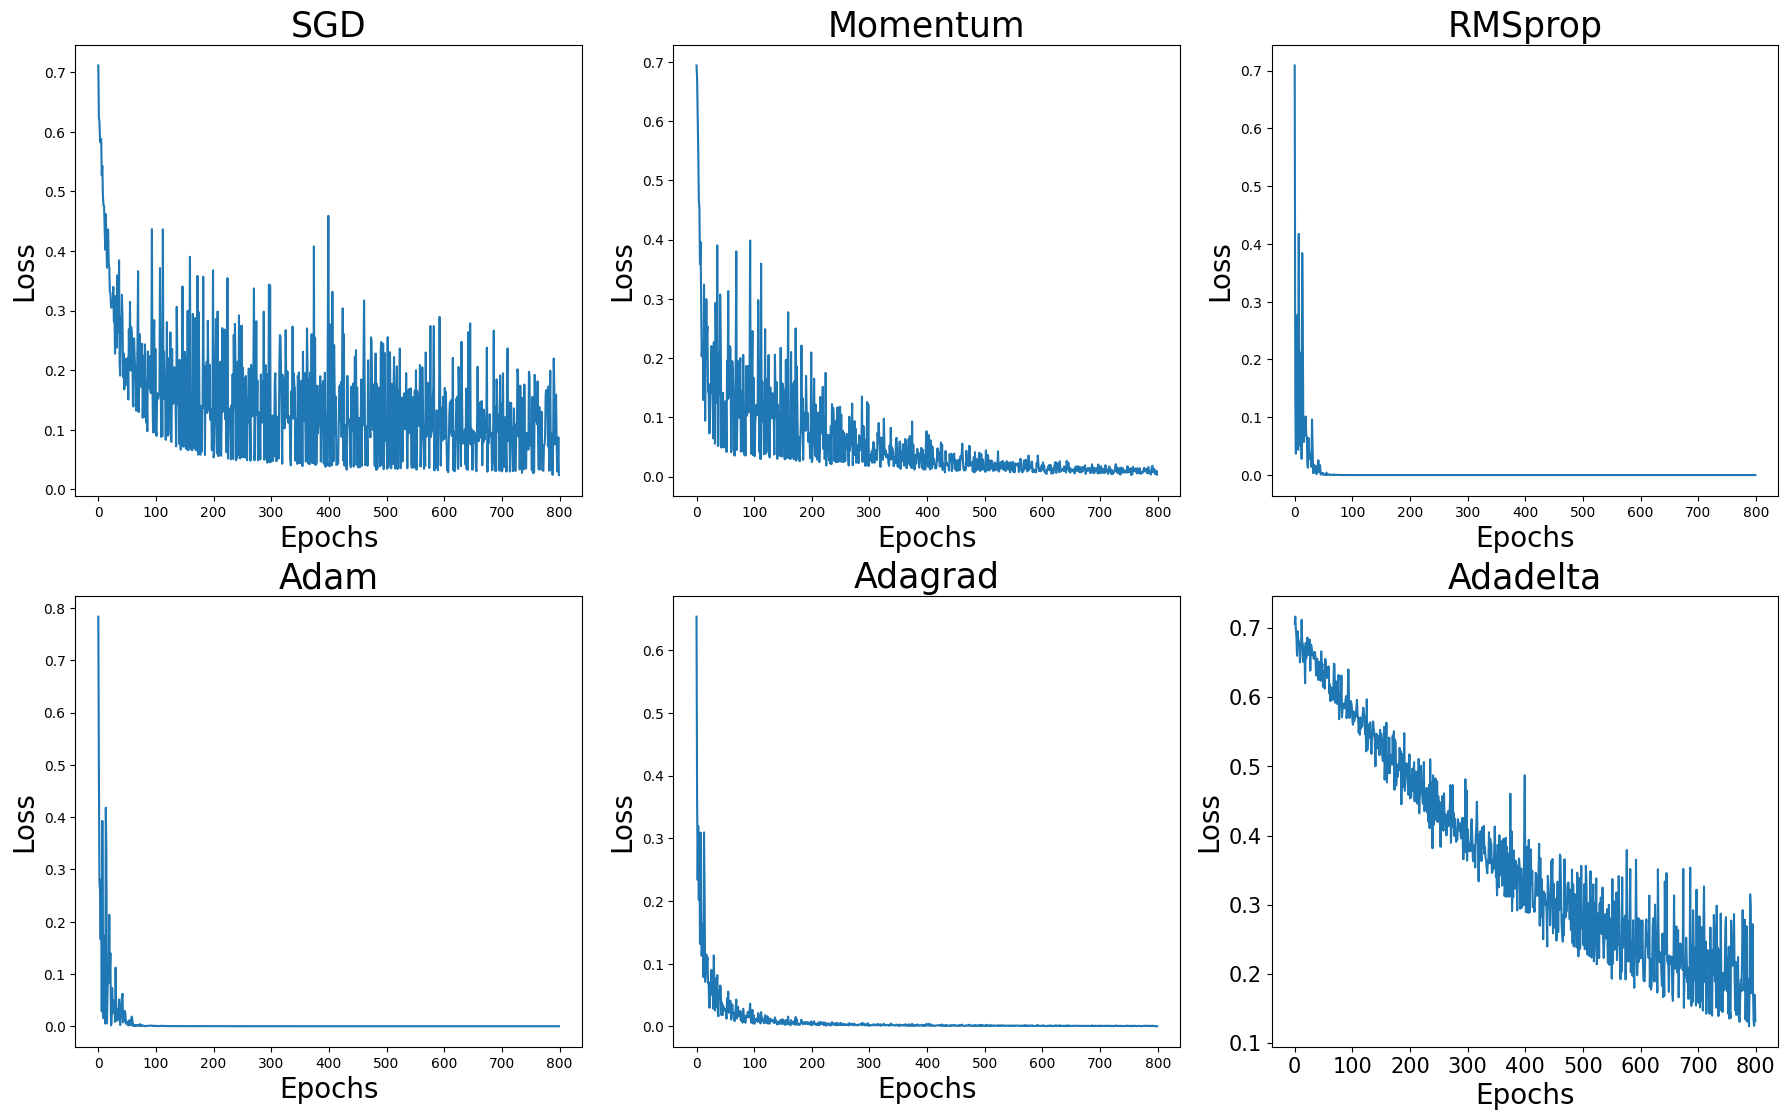

In [86]:
import matplotlib.pyplot as plt

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (optimizer, loss_history, ax) in enumerate(zip(optimzers, losses_his, axes.flatten())):
    ax.plot(loss_history)
    ax.set_title(labels[i], fontsize = 25)
    ax.set_xlabel('Epochs', fontsize = 20)
    ax.set_ylabel('Loss', fontsize = 20)
    ax.legend()

for ax in axes.flatten():
    ax.legend().set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Adam

### one-layer

In [90]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 7, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)

    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    for j in range(min(len(weights), len(lambda_array))):
        for n in range(min(len(weights[j]), len(lambda_array[j]))):
            if abs(weights[j][n]) < 5e-3 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.1  0.05 0.1  ... 0.15 0.05 0.15]
 [0.1  0.05 0.1  ... 0.1  0.1  0.1 ]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]


In [91]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

18 40 0.45
0 4 0.0
5 23 0.21739130434782608
6 27 0.2222222222222222
41 59 0.6949152542372882
2 16 0.125
2 13 0.15384615384615385
1 7 0.14285714285714285
32 51 0.6274509803921569
38 54 0.7037037037037037
24 45 0.5333333333333333
6 24 0.25
38 54 0.7037037037037037
27 49 0.5510204081632653
19 43 0.4418604651162791
30 50 0.6
2 18 0.1111111111111111
38 54 0.7037037037037037
32 51 0.6274509803921569
10 34 0.29411764705882354
41 59 0.6949152542372882
41 59 0.6949152542372882
2 8 0.25
0 1 0.0
10 33 0.30303030303030304
12 36 0.3333333333333333
2 9 0.2222222222222222
0 5 0.0
0 3 0.0
5 20 0.25
0 2 0.0
0 6 0.0
26 48 0.5416666666666666
17 40 0.425
27 49 0.5510204081632653
9 32 0.28125
3 19 0.15789473684210525
3 19 0.15789473684210525
24 45 0.5333333333333333
16 40 0.4
41 59 0.6949152542372882
15 39 0.38461538461538464
5 22 0.22727272727272727
2 14 0.14285714285714285
8 32 0.25
24 45 0.5333333333333333
13 39 0.3333333333333333
41 59 0.6949152542372882
5 21 0.23809523809523808
11 36 0.305555555555555

0.00366

### multiple-layer

In [92]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([2, 24, 28, 29, 31], array([49.00786], dtype=float32))

## Adagrad

### one-layer

In [112]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 2, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 5e-5 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [113]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
13 87 0.14942528735632185
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
13 87 0.14942528735632185
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
0 85 0.0
Variable is select:  0
Variable is select:  1
Variable is select: 

0.132

### Multiple-layer

In [114]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([46, 56, 77], array([42672.05], dtype=float32))

## RMSprop

### one-layer

In [115]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-2 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.1  0.05 0.15 ... 0.05 0.05 0.1 ]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]


In [116]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

8 15 0.5333333333333333
0 1 0.0
14 29 0.4827586206896552
8 14 0.5714285714285714
33 67 0.4925373134328358
9 18 0.5
0 6 0.0
8 11 0.7272727272727273
23 38 0.6052631578947368
33 67 0.4925373134328358
26 41 0.6341463414634146
9 20 0.45
33 67 0.4925373134328358
33 67 0.4925373134328358
19 31 0.6129032258064516
23 35 0.6571428571428571
8 15 0.5333333333333333
33 67 0.4925373134328358
33 67 0.4925373134328358
9 21 0.42857142857142855
33 67 0.4925373134328358
29 50 0.58
9 20 0.45
0 2 0.0
29 50 0.58
4 9 0.4444444444444444
0 5 0.0
3 8 0.375
0 3 0.0
14 29 0.4827586206896552
0 4 0.0
0 7 0.0
20 34 0.5882352941176471
23 38 0.6052631578947368
20 34 0.5882352941176471
9 21 0.42857142857142855
6 9 0.6666666666666666
9 17 0.5294117647058824
17 29 0.5862068965517241
17 29 0.5862068965517241
33 67 0.4925373134328358
29 50 0.58
8 13 0.6153846153846154
29 50 0.58
23 38 0.6052631578947368
19 31 0.6129032258064516
23 38 0.6052631578947368
33 67 0.4925373134328358
8 13 0.6153846153846154
14 25 0.56
14 29 0.482

0.0018100000000000002

### Multiple-layer

In [117]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([2, 24, 27, 28, 29, 31, 32], array([20.720629], dtype=float32))

## VWA Filter

In [118]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import layers

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

num_variables = X.shape[1]
running_times = []
accuracies = []

for x_index in range(num_variables):
    current_x = X[:, x_index].reshape(-1, 1)

    input_dim = 1
    acc = []

    for i in range(10):
        model = keras.Sequential()
        model.add(layers.Dense(264, input_shape=(input_dim,)))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        model.fit(current_x, y, epochs=50, batch_size=32, verbose=0)
        predictions = model.predict(current_x)
        predicted = (predictions > 0.5)
        accuracy = accuracy_score(y, predicted)
        end_time = time.time()
        run_time = end_time - start_time

        acc.append(accuracy)

    avg_accuracy = np.mean(acc)
    
    accuracies.append(avg_accuracy)

print("Accuracies for each variable:", accuracies)

16/16 [==============================] - 0s 1ms/step
Accuracies for each variable: [0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9612, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9612, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 

### one-layer

In [18]:
from collections import defaultdict

accuracies = [0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9612, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9612, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002]
lists = [
    [2,24,28,29,31,32],
    [2, 24, 28, 29, 31],
    [1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 88, 89, 90, 92, 94, 97, 98, 99, 100],
    [46, 56, 77],
    [2,7,24,27,29,31,83],
    [2, 24, 27, 28, 29, 31, 32]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 101), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        if variable in variable_weights:  # Check if the variable exists in variable_weights
            variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [2, 24, 28, 29, 31, 32, 23, 30, 46, 77, 27]


### Multiple-layer

In [19]:
from collections import defaultdict

lists = [
    [2,24,28,29,31,32],
    [1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 88, 89, 90, 92, 94, 97, 98, 99, 100],
    [2,7,24,27,29,31,83]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 101), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        if variable in variable_weights:  # Check if the variable exists in variable_weights
            variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [2, 24, 28, 29, 31, 23, 30]


### one-layer and multiple-layer

In [20]:
from collections import defaultdict

lists = [
    [2, 24, 28, 29, 31],
    [46, 56, 77],
    [2, 24, 27, 28, 29, 31, 32]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 101), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        if variable in variable_weights:  # Check if the variable exists in variable_weights
            variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [2, 24, 28, 29, 31]
